# TüEyeQ dataset validation
Extracking data for comparison with other dataset. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import Normalizer
import csv

### Loading the participant features
The table below holds the info we have on each participant. Each participant has a unique subject ID. The info about the tasks was removed, as it was deemed unnecessary. Our target value should be age / gender.

In [2]:
participant_features = pd.read_csv('TuEyeQ/cft_full.csv', index_col=1)
del participant_features['task_id']
del participant_features['cft_task']
participant_features = participant_features.drop_duplicates()
participant_features.head()

,age,gender,handedness,native_german,native_german_mother,native_language_mother,native_german_father,native_language_father,education_mother,education_father,...,leisure_hobbies,leisure_play_games,leisure_relaxation,leisure_social_activity,leisure_humanitarian_services,leisure_nature_activities,leisure_travel_tourism,study_subject_primary,study_subject_secondary,cft_sum_full
subject,,,,,,,,,,,,,,,,,,,,,
AAB14,19.0,2.0,1.0,1.0,0.0,Türkisch,0.0,Italienisch,2.0,0.0,...,0,0,0,1,0,1,0,"Social sciences, journalism and information",NaN,28.0
AAO14,27.0,2.0,1.0,0.0,0.0,Englisch,0.0,Hindi,NaN,4.0,...,1,0,0,0,0,0,0,"Natural sciences, mathematics and statistics",NaN,30.0
AAR28,29.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,3.0,5.0,...,0,1,0,0,0,1,1,Education,Arts and humanities,35.0
ABT22,21.0,2.0,1.0,1.0,1.0,NaN,0.0,Serbisch,5.0,4.0,...,0,0,0,0,0,0,1,"Business, administration and law",NaN,37.0
ACB13,25.0,1.0,2.0,1.0,1.0,NaN,1.0,NaN,3.0,5.0,...,0,0,0,0,0,0,0,"Business, administration and law",NaN,28.0


### Reading eye tracking features
 Here is what eye tracking features for Some of the participants and some readings have been removed due to too much noise. 

In [3]:
eye_tracking_features_path = 'TuEyeQ/EyeMovementData/split'
arbitrary_eye_tracking_features = pd.read_csv(eye_tracking_features_path+'/ABT22/task_01.csv', index_col=0)
arbitrary_eye_tracking_features['gender'] = participant_features.loc['ABT22']['gender']
arbitrary_eye_tracking_features.head(6)

,starttime,duration,meanPupilDiameter,eye,eventType,eventIdxLeft,eventIdxRight,meanX,meanY,startSaccadeX,startSaccadeY,endSaccadeX,endSaccadeY,microsaccadeCount,microsaccadeAmplitude,microsaccadePeakVelocity,gender
14,3032142,44,NaN,left,saccade,1.0,NaN,NaN,NaN,514.678,410.290,701.580,311.073,NaN,NaN,NaN,2.0
15,3032146,40,NaN,right,saccade,1.0,4.0,NaN,NaN,554.941,409.684,713.569,319.930,NaN,NaN,NaN,2.0
16,3032190,100,3.053042,left,fixation,1.0,NaN,714.207654,299.538000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.0
17,3032190,104,3.053560,right,fixation,1.0,5.0,729.511444,305.095778,NaN,NaN,NaN,NaN,2.0,3.521654,10.08638,2.0
18,3032294,24,NaN,left,saccade,2.0,NaN,NaN,NaN,721.452,301.986,804.455,229.362,NaN,NaN,NaN,2.0
19,3032298,20,NaN,right,saccade,2.0,5.0,NaN,NaN,741.377,292.951,818.070,220.246,NaN,NaN,NaN,2.0


### Appending target values to feature vectors
We want a feature vector to consist of eye tracking features and then a target value in the end, based on the subject ID.

In [4]:
participants = list(set(participant_features.index))

def load_participant(participant_id):
    tasks = []
    
    if not os.path.isdir(eye_tracking_features_path+'/'+participant_id):
        #print(participant_id+' has no readings.')
        return
    
    for task in os.listdir(eye_tracking_features_path+'/'+participant_id):
        df = pd.read_csv(eye_tracking_features_path+'/'+participant_id+'/'+task, index_col=0)
        gender = participant_features.loc[participant_id]['gender']
        age = participant_features.loc[participant_id]['age']
        df['gender'] = gender
        df['age'] = age
        tasks.append(df)
        
    return tasks

def drop_nulls(lst):
    return list(filter(None, lst))

In [5]:
abt22 = load_participant('ABT22')

### Making a heat map
It might be a good idea to visualise the data before attacking it. Perhaps we can even see a difference. Here I make a heatmap of the locations the male and female participants look and scanpaths.

In [6]:
all_males = participant_features[participant_features['gender']==1].index
all_females = participant_features[participant_features['gender']==2].index

all_male_readings = drop_nulls([load_participant(subject) for subject in tqdm(all_males)])
all_female_readings = drop_nulls([load_participant(subject) for subject in tqdm(all_females)])

100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [01:17<00:00,  2.81it/s]


In [7]:
def make_heatmap_scanpath(readings, verbose=True):
    heatmaps, all_x, all_y = [], [], []

    for subject_ind, subject in tqdm(enumerate(readings)):
        for reading_ind, i in enumerate(subject):
            fixations = i[i['eventType']=='fixation']
            mean_x = fixations['meanX']
            mean_y = fixations['meanY']

            if mean_x.shape[0] < 2 and mean_y.shape[0] < 2:
                if verbose:
                    print(f"Reading {reading_ind} on subject {subject_ind} too small to work with.")
                break
            heatmap, x_edges, y_edges = np.histogram2d(mean_x, mean_y, bins=(20,40))
            heatmaps.append(heatmap)
            all_x.append(mean_x)
            all_y.append(mean_y)

    combined_heatmap = sum(heatmaps)
    if verbose:
        print("Drawing...")
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.imshow(combined_heatmap);
    ax = plt.gca() # Inverter x-akse. Den passede ikke af en eller anden årsag.
    ax.invert_xaxis()
    
    plt.subplot(2,1,2)
    for x, y in zip(all_x, all_y):
        plt.plot(x, y, linewidth=0.1/len(readings), c='blue')

In [8]:
#make_heatmap_scanpath(all_male_readings, verbose=False)

In [9]:
#make_heatmap_scanpath(all_female_readings, verbose=False)

### Random Forest Classification - Initial Test

In [10]:
#The features available in all entries - Except start time.
feats = ['duration', 'meanPupilDiameter', 'eventIdxLeft', 'eventIdxRight', 'meanX', 'meanY',
         'startSaccadeX', 'startSaccadeY', 'endSaccadeX', 'endSaccadeY', 'microsaccadeCount',
        'microsaccadeAmplitude', 'microsaccadePeakVelocity']

X_prepared = [i for p in all_male_readings+all_female_readings[:52] for i in p] #52 - fjern
X_prepared = [d.mean() for d in X_prepared] #Take the mean of all values - To make single feature vector
X_prepared = [x for x in X_prepared if not np.isnan(x.loc['gender'])] #Remove nan-values.
X_prepared = [x.fillna(0) for x in X_prepared]
np.random.shuffle(X_prepared)
X = [x.loc[feats] for x in X_prepared] #Take all features except last two
y = [x.loc['gender'] for x in X_prepared] # Take gender (last feature)

C:\Users\lasse\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


2it [00:20, 10.14s/it]
C:\Users\lasse\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Average Accuracy: 0.688877531590662
Average F1: 0.6852908887978499
Average AUC: 0.6891030622211609


C:\Users\lasse\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=5, n_estimators=1000, random_state=42)

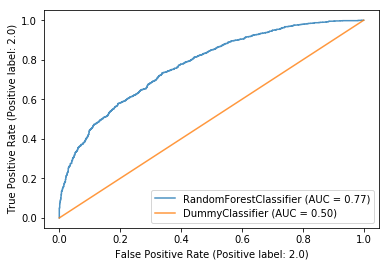

In [11]:
#Fit that model
def fit_roc(X, y, k=2):

    rfc = RandomForestClassifier(
        n_estimators=1000, criterion='entropy', min_samples_split=5,
        min_samples_leaf=1, random_state=42, max_features='sqrt'
    )

    dummy = DummyClassifier()

    acc_score = []
    f1 = []
    auc = []

    X = np.array(X)
    y = np.array(y)

    kf = KFold(n_splits=k, shuffle=False)
    for train_index, test_index in tqdm(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rfc.fit(X_train,y_train)
        pred_values = rfc.predict(X_test)

        acc_score.append(accuracy_score(y_test, pred_values))
        f1.append(f1_score(y_test, pred_values))
        auc.append(roc_auc_score(y_test, pred_values))

    dummy.fit(X_train, y_train)
    ax = plt.gca()
    rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
    rfc_disp = plot_roc_curve(dummy, X_test, y_test, ax=ax, alpha=0.8)

    rfc_avg_acc_score = sum(acc_score)/k
    rfc_avg_f1_score = sum(f1)/k
    rfc_avg_auc_score = sum(auc)/k

    print('Average Accuracy:', rfc_avg_acc_score)
    print('Average F1:', rfc_avg_f1_score)
    print('Average AUC:', rfc_avg_auc_score)
    return rfc

fit_roc(X, y)

## Time to make definitive feature sets!

In [12]:
def get_dist(p1, p2):
    dist = np.sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))
    return dist

def format_dataframe(df, del_eye=True):
    mono = df[df['eye']=='left']
    fixations = mono[mono['eventType']=='fixation']
    saccades = mono[mono['eventType']=='saccade']
    
    if del_eye: #Control to remove, only if the value is there.
        fixations = fixations.drop(['eye', 'eventIdxLeft', 'eventIdxRight','eventType'], axis=1) #Remove eye-column (redundant)
        fixations = fixations.drop(['startSaccadeX', 'endSaccadeX', 'startSaccadeY', 'endSaccadeY'], axis=1) #Remove saccade-specific values (NaN)
    fixations = fixations.fillna(0)
    fixations.replace(np.inf, 0, inplace=True)
    
    if del_eye:
        saccades = saccades.drop(['eye', 'eventIdxLeft', 'eventIdxRight','eventType'], axis=1) #Remove  eye-columns
        saccades = saccades.drop(['meanX', 'meanY', 'meanPupilDiameter', 'microsaccadeCount', 'microsaccadeAmplitude', 'microsaccadePeakVelocity'], axis=1)
        
    saccades['velocity'] = calculate_velocity(saccades['startSaccadeX'], saccades['startSaccadeY'], 
                                              saccades['endSaccadeX'], saccades['endSaccadeY'], saccades['duration'])
    saccades = saccades.fillna(0) #Replace NaN entries with 0
    saccades.replace(np.inf, 0, inplace=True) #Replace infinite values with 0
    
    return [fixations, saccades]

def calculate_velocity(start_x, start_y, end_x, end_y, duration):
    distance = get_dist((start_x, end_x),(start_y, end_y))
    velocity = distance / duration
    return velocity

def calculate_fixation_ratio(fixation_df, saccade_df): #dataframes as input
    fixation_dur = fixation_df['fix_duration'].sum()
    saccade_dur = saccade_df['sac_duration'].sum()
    if fixation_dur == 0 or saccade_dur == 0:
        return 0
    return fixation_dur / saccade_dur

def transform_to_vector(fixations, saccades):
    fixations = fixations.add_prefix('fix_')
    saccades = saccades.add_prefix('sac_')
    
    #Get single values from dataframe
    fixations_sums = fixations.sum()
    saccades_sums = saccades.sum()
    fixations_means = fixations.mean()
    saccades_means = saccades.mean()
    fixations_min = fixations.min()
    saccades_min = saccades.min()
    fixations_max = fixations.max()
    saccades_max = saccades.max()
    fixations_std = fixations.std()
    saccades_std = saccades.std()
    
    fix_dur_ratio = pd.Series(calculate_fixation_ratio(fixations, saccades), index=['fixdur_ratio'])
    
    #Add suffixes to columns
    fixations_sums = fixations_sums.add_suffix('_sum')
    saccades_sums = saccades_sums.add_suffix('_sum')
    fixations_means = fixations_means.add_suffix('_mean')
    saccades_means = saccades_means.add_suffix('_mean')
    fixations_min = fixations_min.add_suffix('_min')
    saccades_min = saccades_min.add_suffix('_min')
    fixations_max = fixations_max.add_suffix('_max')
    saccades_max = saccades_max.add_suffix('_max')
    fixations_std = fixations_std.add_suffix('_std')
    saccades_std = saccades_std.add_suffix('_std')
    
    return pd.concat((fixations_sums, saccades_sums, fixations_means, saccades_means,
                     fixations_min, saccades_min, fixations_max, saccades_max,
                     fixations_std, saccades_std))
    

def participant_to_dataframe(participant_readings):
    #Converts multiple participant readings into a single dataframe, each row being a test trial.
    participant_df = pd.DataFrame()
    age, gender = participant_readings[0]['age'], participant_readings[0]['gender']
    
    #loop through each trial of participant readings
    for trial in participant_readings:
        #Create two clean dataframes (fixation, saccade)
        fixations, saccades = format_dataframe(trial.drop(['age', 'gender'], axis=1))
        feature_vector = transform_to_vector(fixations, saccades)
        participant_df = participant_df.append(feature_vector, ignore_index=True)
    
    participant_df = participant_df.assign(age=age.iloc[0], gender=gender.iloc[0]) #Add target values in end
    
    return participant_df
        
    
def multiple_readings_to_dataframe(participant_readings):
    #Converts a list of participant readings into a single dataframe.
    participant_dfs = []
    
    for i in tqdm(range(len(participant_readings))):
        participant_dfs.append(participant_to_dataframe(participant_readings[i]))
    
    return pd.concat(participant_dfs)

In [13]:
features = multiple_readings_to_dataframe(all_male_readings+all_female_readings[:52])

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:53<00:00,  1.94it/s]


In [14]:
feats = features.columns
feats = feats.drop(['age', 'gender'])
features = features.sample(frac=1) #Shuffle dataset

X = features[feats]
y = features['gender']
X = X.fillna(0)

In [15]:
X["fix_meanPupilDiameter_max"]

29    3.613702
2     3.964300
7     3.414944
33    3.928960
52    3.371265
        ...   
44    3.649271
52    3.510970
46    3.570653
2     3.782262
47    3.810679
Name: fix_meanPupilDiameter_max, Length: 5824, dtype: float64

5it [02:44, 32.94s/it]
C:\Users\lasse\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Average Accuracy: 0.784852735129714
Average F1: 0.7924918006105399
Average AUC: 0.7848250154505247


C:\Users\lasse\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


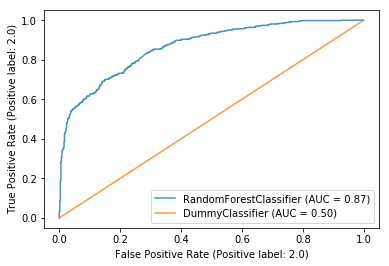

In [16]:
model = fit_roc(X,y,k=5)

In [17]:
importances = zip(model.feature_importances_, X.columns)
importances = [i for i in importances]
sorted(importances)[::-1][:15] #5 most important features.

[(0.04333448966967856, 'fix_meanPupilDiameter_max'),
 (0.04197680871433192, 'fix_microsaccadeAmplitude_std'),
 (0.0322620853544438, 'fix_microsaccadeCount_mean'),
 (0.03154191666311649, 'fix_meanPupilDiameter_mean'),
 (0.03134413066896974, 'sac_starttime_min'),
 (0.030814209321630953, 'sac_starttime_mean'),
 (0.03075054697858917, 'fix_starttime_min'),
 (0.0303651565303182, 'sac_starttime_max'),
 (0.030038061004398372, 'fix_starttime_max'),
 (0.029916331156443463, 'fix_starttime_mean'),
 (0.022289071421326176, 'fix_microsaccadeAmplitude_max'),
 (0.020540910992461036, 'fix_microsaccadeCount_std'),
 (0.018799115732377303, 'fix_microsaccadePeakVelocity_mean'),
 (0.0185564814894006, 'fix_microsaccadeAmplitude_mean'),
 (0.018334596210512012, 'fix_meanPupilDiameter_min')]

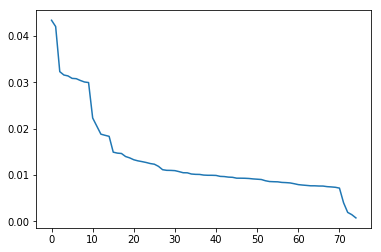

In [18]:
plt.plot([i[0] for i in sorted(importances)[::-1]])

### Export some stuff

In [65]:
# Mapping values

def normalize(feature_list):
    feature_list = [i/np.nanmax(feature_list) for i in feature_list]
    return feature_list

In [66]:
export_item_1 = X["fix_duration_mean"].tolist()
export_item_2 = X["fix_duration_min"].tolist()
export_item_3 = X["fix_duration_max"].tolist()
export_item_4 = X["fix_duration_std"].tolist()

export_item_5 = X["sac_duration_mean"].tolist()
export_item_6 = X["sac_duration_min"].tolist()
export_item_7 = X["sac_duration_max"].tolist()
export_item_8 = X["sac_duration_std"].tolist()

export_item_9 = X["fix_meanPupilDiameter_mean"].tolist()
export_item_10 = X["fix_meanPupilDiameter_min"].tolist()
export_item_11 = X["fix_meanPupilDiameter_max"].tolist()
export_item_12 = X["fix_meanPupilDiameter_std"].tolist()

export_item_13 = X["fix_meanX_mean"].tolist()
export_item_14 = X["fix_meanX_min"].tolist()
export_item_15 = X["fix_meanX_max"].tolist()
export_item_16 = X["fix_meanX_std"].tolist()

export_item_17 = X["fix_meanY_mean"].tolist()
export_item_18 = X["fix_meanY_min"].tolist()
export_item_19 = X["fix_meanY_max"].tolist()
export_item_20 = X["fix_meanY_std"].tolist()

export_item_21 = X["fix_microsaccadeCount_mean"].tolist()
export_item_22 = X["fix_microsaccadeCount_min"].tolist()
export_item_23 = X["fix_microsaccadeCount_max"].tolist()
export_item_24 = X["fix_microsaccadeCount_std"].tolist()

export_item_25 = X["fix_microsaccadeAmplitude_mean"].tolist()
export_item_26 = X["fix_microsaccadeAmplitude_min"].tolist()
export_item_27 = X["fix_microsaccadeAmplitude_max"].tolist()
export_item_28 = X["fix_microsaccadeAmplitude_std"].tolist()

export_item_29 = X["fix_microsaccadePeakVelocity_mean"].tolist()
export_item_30 = X["fix_microsaccadePeakVelocity_min"].tolist()
export_item_31 = X["fix_microsaccadePeakVelocity_max"].tolist()
export_item_32 = X["fix_microsaccadePeakVelocity_std"].tolist()

export_item_33 = X["sac_startSaccadeX_mean"].tolist()
export_item_34 = X["sac_startSaccadeX_min"].tolist()
export_item_35 = X["sac_startSaccadeX_max"].tolist()
export_item_36 = X["sac_startSaccadeX_std"].tolist()

export_item_37 = X["sac_startSaccadeY_mean"].tolist()
export_item_38 = X["sac_startSaccadeY_min"].tolist()
export_item_39 = X["sac_startSaccadeY_max"].tolist()
export_item_40 = X["sac_startSaccadeY_std"].tolist()

export_item_41 = X["sac_endSaccadeX_mean"].tolist()
export_item_42 = X["sac_endSaccadeX_min"].tolist()
export_item_43 = X["sac_endSaccadeX_max"].tolist()
export_item_44 = X["sac_endSaccadeX_std"].tolist()

export_item_45 = X["sac_endSaccadeY_mean"].tolist()
export_item_46 = X["sac_endSaccadeY_min"].tolist()
export_item_47 = X["sac_endSaccadeY_max"].tolist()
export_item_48 = X["sac_endSaccadeY_std"].tolist()

In [67]:
export_item_1 = normalize(export_item_1)
export_item_2 = normalize(export_item_2)
export_item_3 = normalize(export_item_3)
export_item_4 = normalize(export_item_4)
export_item_5 = normalize(export_item_5)
export_item_6 = normalize(export_item_6)
export_item_7 = normalize(export_item_7)
export_item_8 = normalize(export_item_8)
export_item_9 = normalize(export_item_9)
export_item_10 = normalize(export_item_10)
export_item_11 = normalize(export_item_11)
export_item_12 = normalize(export_item_12)
export_item_13 = normalize(export_item_13)
export_item_14 = normalize(export_item_14)
export_item_15 = normalize(export_item_15)
export_item_16 = normalize(export_item_16)
export_item_17 = normalize(export_item_17)
export_item_18 = normalize(export_item_18)
export_item_19 = normalize(export_item_19)
export_item_20 = normalize(export_item_20)
export_item_21 = normalize(export_item_21)
export_item_22 = normalize(export_item_22)
export_item_23 = normalize(export_item_23)
export_item_24 = normalize(export_item_24)
export_item_25 = normalize(export_item_25)
export_item_26 = normalize(export_item_26)
export_item_27 = normalize(export_item_27)
export_item_28 = normalize(export_item_28)
export_item_29 = normalize(export_item_29)
export_item_30 = normalize(export_item_30)
export_item_31 = normalize(export_item_31)
export_item_32 = normalize(export_item_32)
export_item_33 = normalize(export_item_33)
export_item_34 = normalize(export_item_34)
export_item_35 = normalize(export_item_35)
export_item_36 = normalize(export_item_36)
export_item_37 = normalize(export_item_37)
export_item_38 = normalize(export_item_38)
export_item_39 = normalize(export_item_39)
export_item_40 = normalize(export_item_40)
export_item_41 = normalize(export_item_41)
export_item_42 = normalize(export_item_42)
export_item_43 = normalize(export_item_43)
export_item_44 = normalize(export_item_44)
export_item_45 = normalize(export_item_45)
export_item_46 = normalize(export_item_46)
export_item_47 = normalize(export_item_47)
export_item_48 = normalize(export_item_48)

In [68]:
X_to_export = []

for i in range(len(export_item_1)):
    X_to_export.append([
        export_item_1[i],
        export_item_2[i],
        export_item_3[i],
        export_item_4[i],
        export_item_5[i],
        export_item_6[i],
        export_item_7[i],
        export_item_8[i],
        export_item_9[i],
        export_item_10[i],
        export_item_11[i],
        export_item_12[i],
        export_item_13[i],
        export_item_14[i],
        export_item_15[i],
        export_item_16[i],
        export_item_17[i],
        export_item_18[i],
        export_item_19[i],
        export_item_20[i],
        export_item_21[i],
        export_item_22[i],
        export_item_23[i],
        export_item_24[i],
        export_item_25[i],
        export_item_26[i],
        export_item_27[i],
        export_item_28[i],
        export_item_29[i],
        export_item_30[i],
        export_item_31[i],
        export_item_32[i],
        export_item_33[i],
        export_item_34[i],
        export_item_35[i],
        export_item_36[i],
        export_item_37[i],
        export_item_38[i],
        export_item_39[i],
        export_item_40[i],
        export_item_41[i],
        export_item_42[i],
        export_item_43[i],
        export_item_44[i],
        export_item_45[i],
        export_item_46[i],
        export_item_47[i],
        export_item_48[i]
    ])

In [69]:
y_to_export = y.tolist()
for count, item in enumerate(y_to_export):
    if item == 1:
        y_to_export[count] = 0
    if item == 2:
        y_to_export[count] = 1

In [70]:
with open('TuEyeQ_X.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(X_to_export)

with open('TuEyeQ_y.csv', 'w') as f:
    writer = csv.writer(f)
    for val in y_to_export:
        writer.writerow([val])

In [71]:
X.columns

Index(['fix_starttime_sum', 'fix_duration_sum', 'fix_meanPupilDiameter_sum',
       'fix_meanX_sum', 'fix_meanY_sum', 'fix_microsaccadeCount_sum',
       'fix_microsaccadeAmplitude_sum', 'fix_microsaccadePeakVelocity_sum',
       'sac_starttime_sum', 'sac_duration_sum', 'sac_startSaccadeX_sum',
       'sac_startSaccadeY_sum', 'sac_endSaccadeX_sum', 'sac_endSaccadeY_sum',
       'sac_velocity_sum', 'fix_starttime_mean', 'fix_duration_mean',
       'fix_meanPupilDiameter_mean', 'fix_meanX_mean', 'fix_meanY_mean',
       'fix_microsaccadeCount_mean', 'fix_microsaccadeAmplitude_mean',
       'fix_microsaccadePeakVelocity_mean', 'sac_starttime_mean',
       'sac_duration_mean', 'sac_startSaccadeX_mean', 'sac_startSaccadeY_mean',
       'sac_endSaccadeX_mean', 'sac_endSaccadeY_mean', 'sac_velocity_mean',
       'fix_starttime_min', 'fix_duration_min', 'fix_meanPupilDiameter_min',
       'fix_meanX_min', 'fix_meanY_min', 'fix_microsaccadeCount_min',
       'fix_microsaccadeAmplitude_min', 'fi